<h1 id="title">Capstone Project - The Battle of the Neighborhoods: Week 2</h1
<h3 id="subtitle">Course by IBM/Coursera</h3

## Classification of nonprofit organizations based on scores in the city of Philadelphia


<h3>Table of Contents</h3>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
          <a href="#intro">1. Introduction and Business Problem</a><br>
          <a href="#data">2. Data Source</a>
              <ul>
                <li><a href="read">2.1. Prepare/run Charity Navigator GET/ORGANIZATION API</a></li>
                <li><a href="readirs">2.2. Read IRS Codes from a GitHub File</a></li>
                <li><a href="norm">2.3. Normalize JSON data returned from the Charity Navigator API</a></li>
                <li><a href="prep">2.4. Data preparation </a></li>
              </ul>
          <a href="#method">3. Methodology</a><br>
          <a href="#analysis">4. Analysis and Results</a><br>
            <ul>
                <li><a href="desc">4.1. Data Exploration and Descriptive Analysis</a></li>
                <li><a href="kmean">4.2. K-Means  Method for Clustering</a></li>
            </ul>  
          <a href="#disc">5. Discussion</a><br>
          <a href="#conclusions">6. Conclusions</a><br>
          <a href="#refren">7. References</a><br>
         
                
</div>

<hr>

## 1. Introduction: Business Problem, Scope and Background

The majority of nonprofit organizations rely upon donors as an important source of their funding structure, according to some surveys an average of 34 percent of these organization’s revenues come from individual’s contributions. In recent years several scandals involving nonprofit mishandling of funds and other misconducts, have impacted the philanthropy domain and individual’s faith on how their contributions are being used.

The goal and interest of this study is to explore and provide individuals and potential donors with the necessary information to make educated decisions for their contributions to major nonprofits organizations located in the city of Philadelphia. The information is based on different types of scores processed by an evaluator organization in this field.
The scope of this analysis will focus on nonprofit organizations with IRS status 501(c)(3) that generate at least 1$ millions of dollars in revenue for two consecutive year.
Considering this problem, I will group the organizations, subject to this study, and provide relevant information and graphs of the those that meet best practices both in the financial and accountability areas, thus donors can have more information at the time of planning their donations. 


### Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#seaborn
import seaborn as sns

#preprocessing
from sklearn import preprocessing

#KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

print('Libraries imported.')

Libraries imported.


## 2. Data source and preparation

### 2.1. Prepare/run Charity Navigator GET/ORGANIZATION API


For this analysis the data was obtained from an organization called __"Charity Data Navigator"__. This organization  collects financial and other information for nonprofits organizations. This organization provides APIs, similar as __"Four Square"__, to get reference data of nonprofit and charities organization including rating list and other  content.

This API was preare using an application id and a key, and customized to retrive all nonprofit organizations in the city of __Philadelphia__.


In [2]:
import requests
URL='https://api.data.charitynavigator.org/v2/Organizations?app_id=25de6cb6&app_key=8913aca13c073059fd92c96b801ee9c0&pageSize=9999&city=philadelphia'
response=requests.get(URL)
data = response.json()
print('Read data from Charity Navigator...done ')


Read data from Charity Navigator...done 


### 2.2. Read IRS Codes from a GitHub File

I created this csv file from the IRS nonprofit general code description, and it will be merged with the nonprofit codes obtained via Charty Navigator

In [3]:
irsCodes_URL  = 'https://raw.githubusercontent.com/aperezy17/Coursera_Capstone/master/irs_codes.csv'
df_irsCodes = pd.read_csv(irsCodes_URL, index_col=0)
print('Read data from irsCodes CSV...done ')


Read data from irsCodes CSV...done 


### 2.3. Normalize JSON data returned from the Charity Navigator API

In [4]:
res =json_normalize(data)
print('JSON Normalized ...done ')

JSON Normalized ...done 


### 2.4. Data Preparation
- Create working dataframe
- Select Features
- Merge Address into one field
- Elminate all the nonprofit with no scores or ratings

In [5]:
df_np_rating = res.filter(['charityName',
                           'ein',
                           'irsClassification.classification',
                           'irsClassification.nteeType',
                           'irsClassification.latest990',
                           'irsClassification.assetAmount',
                           'mailingAddress.stateOrProvince',
                           'mailingAddress.city',
                           'mailingAddress.postalCode',
                           'mailingAddress.streetAddress1',
                           'mailingAddress.streetAddress2',
                           'irsClassification.nteeCode',
                           'currentRating.score',
                           'currentRating.rating',
                           'currentRating.financialRating.score',
                           'currentRating.financialRating.rating',
                           'currentRating.accountabilityRating.score',
                           'currentRating.accountabilityRating.rating'],axis=1)
                                
df_np_rating = df_np_rating.rename(columns={'charityName':'npOrganization',
                                            'irsClassification.classification': 'irsClass',
                                            'irsClassification.nteeType': 'irsType',
                                            'irsClassification.latest990': 'irs990',
                                            'irsClassification.assetAmount': 'irsAsset',
                                            'mailingAddress.stateOrProvince': 'State',
                                            'mailingAddress.city': 'City',
                                            'mailingAddress.postalCode': 'postalCode',
                                            'mailingAddress.streetAddress1': 'Address1',
                                            'mailingAddress.streetAddress2': 'Address2',
                                            'irsClassification.nteeCode': 'irsCode',
                                            'currentRating.score': 'Score',
                                            'currentRating.rating':'Rating',
                                            'currentRating.financialRating.score':'finScore', 
                                            'currentRating.financialRating.rating':'finRating',
                                            'currentRating.accountabilityRating.score':'acctScore',
                                            'currentRating.accountabilityRating.rating':'acctRating'})
                                                    

df_np_rating['Address']=df_np_rating['Address1'] \
                        +' '+df_np_rating['City']+' '+df_np_rating['State'] \
                        +' '+df_np_rating['postalCode']

df_np_rating = df_np_rating[df_np_rating['Score'].notna()]

df_np_rating.head(5)


,npOrganization,ein,irsClass,irsType,irs990,irsAsset,State,City,postalCode,Address1,Address2,irsCode,Score,Rating,finScore,finRating,acctScore,acctRating,Address
72,Foundation for Individual Rights in Education,043467254,Educational Organization,"Civil Rights, Social Action, Advocacy","June, 2019",18917162.0,PA,Philadelphia,19106,510 Walnut St.,Suite 1250,R63,96.32,4.0,95.75,4.0,97.0,4.0,510 Walnut St. Philadelphia PA 19106
145,American Bible Society,131623885,Religious Organization,"Religion-Related, Spiritual Development","June, 2018",784426446.0,PA,Philadelphia,19106,101 N Independence Mall E Fl 8,None,X20,85.63,3.0,81.32,3.0,92.0,4.0,101 N Independence Mall E Fl 8 Philadelphia PA...
146,Maccabi USA/Sports for Israel,131810938,Educational Organization,"Recreation, Sports, Leisure, Athletics","December, 2018",935469.0,PA,Philadelphia,19102,1511 Walnut,Suite 401,N71,87.01,3.0,81.63,3.0,100.0,4.0,1511 Walnut Philadelphia PA 19102
344,Broad Street Ministry,202760310,Charitable Organization,"Religion-Related, Spiritual Development","December, 2018",8724135.0,PA,Philadelphia,19107,315 South Broad Street,None,X20,89.78,3.0,87.97,3.0,92.0,4.0,315 South Broad Street Philadelphia PA 19107
360,Community Partnership School,203195763,Educational Organization,Educational Institutions and Related Activities,"June, 2018",12111833.0,PA,Philadelphia,19121,3033 West Glenwood Avenue,None,B20,92.29,4.0,89.87,3.0,96.0,4.0,3033 West Glenwood Avenue Philadelphia PA 19121


### Obtain nonprofit organizations geographical coordinates using GeoPy

In [8]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="us_explorer")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)
df_np_rating["Coordinates"]=df_np_rating["Address"].apply(geolocator.geocode)
print('Coordinates for Non-profit organizations...Done')

Coordinates for Non-profit organizations...Done


### Add Longitude and Latitude features to the dataframe

In [9]:
df_np_rating["Latitude"]=df_np_rating["Coordinates"].apply(lambda x: x.latitude if x != None else None)
df_np_rating["Longitude"]=df_np_rating["Coordinates"].apply(lambda x: x.longitude if x != None else None)
df_np_rating = df_np_rating.reset_index(drop=True)
print('Coordinates for Non-profit organizations...Done')
df_np_rating.head(5)

Coordinates for Non-profit organizations...Done


,npOrganization,ein,irsClass,irsType,irs990,irsAsset,State,City,postalCode,Address1,Address2,irsCode,Score,Rating,finScore,finRating,acctScore,acctRating,Address,Coordinates,Latitude,Longitude
0,Foundation for Individual Rights in Education,043467254,Educational Organization,"Civil Rights, Social Action, Advocacy","June, 2019",18917162.0,PA,Philadelphia,19106,510 Walnut St.,Suite 1250,R63,96.32,4.0,95.75,4.0,97.0,4.0,510 Walnut St. Philadelphia PA 19106,"(Bagel Factory On Independence, 510, Walnut St...",39.947321,-75.150032
1,American Bible Society,131623885,Religious Organization,"Religion-Related, Spiritual Development","June, 2018",784426446.0,PA,Philadelphia,19106,101 N Independence Mall E Fl 8,None,X20,85.63,3.0,81.32,3.0,92.0,4.0,101 N Independence Mall E Fl 8 Philadelphia PA...,None,NaN,NaN
2,Maccabi USA/Sports for Israel,131810938,Educational Organization,"Recreation, Sports, Leisure, Athletics","December, 2018",935469.0,PA,Philadelphia,19102,1511 Walnut,Suite 401,N71,87.01,3.0,81.63,3.0,100.0,4.0,1511 Walnut Philadelphia PA 19102,"(1511, Walnut Street, Rittenhouse Square, Phil...",39.949855,-75.166480
3,Broad Street Ministry,202760310,Charitable Organization,"Religion-Related, Spiritual Development","December, 2018",8724135.0,PA,Philadelphia,19107,315 South Broad Street,None,X20,89.78,3.0,87.97,3.0,92.0,4.0,315 South Broad Street Philadelphia PA 19107,"(Broad Street Ministry, 315, South Broad Stree...",39.946121,-75.164504
4,Community Partnership School,203195763,Educational Organization,Educational Institutions and Related Activities,"June, 2018",12111833.0,PA,Philadelphia,19121,3033 West Glenwood Avenue,None,B20,92.29,4.0,89.87,3.0,96.0,4.0,3033 West Glenwood Avenue Philadelphia PA 19121,"(3033, West Glenwood Avenue, Strawberry Mansio...",39.981929,-75.183975


### Identity nonprofit with coordinates problems and correct the issues 

In [10]:
df_np_rating1 = df_np_rating[df_np_rating['Latitude'].isna()]
print('The following Non-profit Organizations have address problems in the Dataframe,')
print('It will calclulated manually in the following cell...')
df_np_rating1['npOrganization']

The following Non-profit Organizations have address problems in the Dataframe,
It will calclulated manually in the following cell...


1                         American Bible Society
6                    Medical Students for Choice
23                       Settlement Music School
33                                          WHYY
36                        Eisenhower Fellowships
50            Support Center for Child Advocates
70                        The Attic Youth Center
75                           Women's Law Project
77    National Museum of American Jewish History
83                                         Eluna
Name: npOrganization, dtype: object

In [11]:
df_np_rating.loc[(df_np_rating.npOrganization == 'American Bible Society'), \
                                                  ['Latitude', 'Longitude']] = '39.951037', '-75.148034'
df_np_rating.loc[(df_np_rating.npOrganization == 'Medical Students for Choice'), \
                                                  ['Latitude', 'Longitude']] = '40.006737', '-75.152310'
df_np_rating.loc[(df_np_rating.npOrganization == 'Settlement Music School'), \
                                                  ['Latitude', 'Longitude']] = '39.942396', '-75.150762'
df_np_rating.loc[(df_np_rating.npOrganization == 'WHYY'), \
                                                  ['Latitude', 'Longitude']] = '39.959950', '-75.148622'
df_np_rating.loc[(df_np_rating.npOrganization == 'Eisenhower Fellowships'), \
                                                  ['Latitude', 'Longitude']] = '39.948330', '-75.168122'
df_np_rating.loc[(df_np_rating.npOrganization == 'Support Center for Child Advocates'), \
                                                  ['Latitude', 'Longitude']] = '39.948347', '-75.168090'
df_np_rating.loc[(df_np_rating.npOrganization == 'The Attic Youth Center'), \
                                                  ['Latitude', 'Longitude']] = '39.947858', '-75.167288' 

df_np_rating.loc[(df_np_rating.npOrganization == "Women's Law Project"), \
                                                  ['Latitude', 'Longitude']] = '39.949161', '-75.155281'

df_np_rating.loc[(df_np_rating.npOrganization == 'National Museum of American Jewish History'), \
                                                  ['Latitude', 'Longitude']] = '39.950482', '-75.148545'

df_np_rating.loc[(df_np_rating.npOrganization == 'Eluna'), \
                                                  ['Latitude', 'Longitude']] = '39.954498', '-75.167878'

df_np_rating["Latitude"] = df_np_rating.Latitude.astype(float) 
df_np_rating["Longitude"] = df_np_rating.Longitude.astype(float) 
print('Problems with coordinates with Nonprofit Organizations fixed...')

Problems with coordinates with Nonprofit Organizations fixed...


## 3. Methodology
I used the Charity Navigator APIs to get the research and reference data, covering charitable organizations, ratings, lists, and other related content.

The data models of these APIs are based in the industry standard OpenAPI format for interactive documentation and overall interoperability. I created a free account and defined an application (app_id) and a key (app_key). 
I utilized the GET Organizations API to retrieve a list of the organizations available in the Charity Navigator 	Data Store and it is the main source of data for this study. As I mentioned in the previous paragraph, the candidate for the study are 85 nonprofit organizations in the city of Philadelphia with revenues higher to 1$ Million in two consecutive years.

I also used GeoPy and Folium libraries to obtain geographical locations (latitude and longitude) of these 85 candidates and plot them on a city map. This will help individuals and donors in their analysis process.
I break my analysis in two different segments. The first one is an exploratory data using descriptive analysis and the second part I will use the unsupervised learning method K-means to find the different clusters of nonprofit organizations based on their Financial and Accountability scores. 


## 4. Analysis and Results

## 4.1. Data Exploration and Descriptive Analysis

#### Use Folium library to plot the nonprofit candidates location in the city of Philadelphia

In [12]:
address = 'Philadelphia, PA'
geolocator = Nominatim(user_agent="usa_explorer")
location = geolocator.geocode(address)
tor_latitude = location.latitude
tor_longitude = location.longitude
print('The geograpical coordinate of Philadelphia, USA {}, {}.'.format(tor_latitude, tor_longitude))

The geograpical coordinate of Philadelphia, USA 39.9527237, -75.1635262.


In [13]:
# create map of Philadelphia Non-profit Organizations latitude and longitude values
#
map_philadelphia = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=11)

# add markers to map
for lat, lng, npOrganization, Address in zip(df_np_rating['Latitude'], df_np_rating['Longitude'],
                                           df_np_rating['npOrganization'], df_np_rating['Address']):
    label = '{}, {}'.format(npOrganization, Address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_philadelphia)  
    

map_philadelphia

### Display a histogram of the number of nonprofits by Total Score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f204750>]],
      dtype=object)

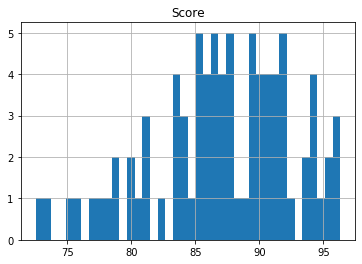

In [14]:
df_np_rating.hist(column='Score', bins=40)

### Display a histogram of the number of nonprofits by Financial  Score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2708ec90>]],
      dtype=object)

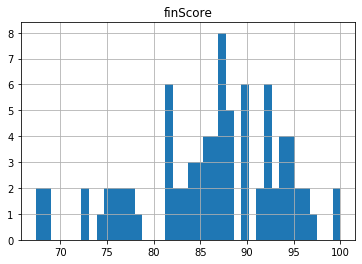

In [15]:
df_np_rating.hist(column='finScore',bins=40)

### Display a histogram of the number of nonprofits by Accountability Score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a27230d50>]],
      dtype=object)

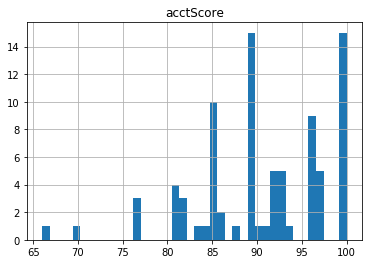

In [16]:
df_np_rating.hist(column='acctScore', bins=40)

### Frequency of Distribution by nonprofit type

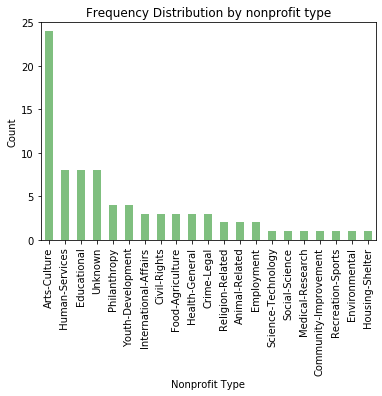

   irsCode  codeCount            Description
0        A         24           Arts-Culture
1        P          8         Human-Services
2        B          8            Educational
3        Z          8                Unknown
4        T          4           Philanthropy
5        O          4      Youth-Development
6        Q          3  International-Affairs
7        R          3           Civil-Rights
8        K          3       Food-Agriculture
9        E          3         Health-General
10       I          3            Crime-Legal
11       X          2       Religion-Related
12       D          2         Animal-Related
13       J          2             Employment
14       U          1     Science-Technology
15       V          1         Social-Science
16       H          1       Medical-Research
17       S          1  Community-Improvement
18       N          1      Recreation-Sports
19       C          1          Environmental
20       L          1        Housing-Shelter


In [17]:
# df_np_rating_itype = df_np_rating['irsCode'].str[:1]
df_np_rating["irsCode"].fillna("Z", inplace = True)
df_np_rating['irsCodeA'] = df_np_rating.irsCode.str[:1]
df_np_irsCode = df_np_rating.filter(['irsCodeA'])
df_np_irsCode["codeCount"] =99
df_np_irsCode = df_np_irsCode['irsCodeA'].value_counts().rename_axis('irsCodeA').reset_index(name='codeCount')
df_np_irsCode = df_np_irsCode.rename(columns={'irsCodeA':'irsCode'})
#
# Merge With isrCode Description
#
df_np_irsCodeC = pd.merge(df_np_irsCode, df_irsCodes, on='irsCode', left_index=True)
df_np_irsCodeC = df_np_irsCodeC.reset_index(drop=True)
#
# Plot the freuqency Distribution By nonProfit Type
#
df_np_irsCodeC.plot(x='Description', y=(['codeCount']),kind="bar",color="g",legend=None,alpha=0.5)
plt.title('Frequency Distribution by nonprofit type')
plt.ylabel('Count')
plt.xlabel('Nonprofit Type')
plt.axis([None, None, 0, 25])
plt.show()
print(df_np_irsCodeC)

### Top 10 nonprofits with higher overall scores

In [18]:
df_np_top10=df_np_rating.filter(['npOrganization', 'Score', 'irsCodeA'])
df_np_top10 = df_np_top10.reset_index(drop=True)
df_np_top10=df_np_top10.sort_values(by='Score',ascending = False).head(10)
print('-------------------------------------------------------------------------------')
print('Top 10 nonprofit with higher overall scores')
print('-------------------------------------------------------------------------------')
print(df_np_top10)

-------------------------------------------------------------------------------
Top 10 nonprofit with higher overall scores
-------------------------------------------------------------------------------
                                      npOrganization  Score irsCodeA
0      Foundation for Individual Rights in Education  96.32        R
10          Women's Community Revitalization Project  95.90        L
59                                      Project HOME  95.89        P
72          Children's Scholarship Fund Philadelphia  95.72        B
27                              Philadelphia Futures  95.47        B
31                               Woodmere Art Museum  94.69        A
41                 Foreign Policy Research Institute  94.52        Q
36                            Eisenhower Fellowships  94.49        Q
55  Philadelphia Volunteers for the Indigent Program  94.43        I
63                                       Gesu School  94.27        B


### Top 10 Non-profit Organizations >1M Asset in Philadelphia

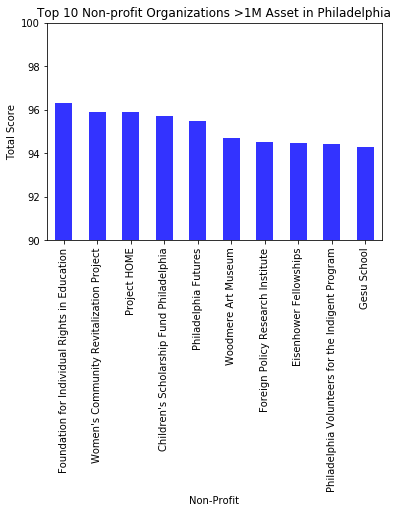

                                      npOrganization  Score irsCodeA
0      Foundation for Individual Rights in Education  96.32        R
10          Women's Community Revitalization Project  95.90        L
59                                      Project HOME  95.89        P
72          Children's Scholarship Fund Philadelphia  95.72        B
27                              Philadelphia Futures  95.47        B
31                               Woodmere Art Museum  94.69        A
41                 Foreign Policy Research Institute  94.52        Q
36                            Eisenhower Fellowships  94.49        Q
55  Philadelphia Volunteers for the Indigent Program  94.43        I
63                                       Gesu School  94.27        B


In [19]:
df_np_top10.plot(x='npOrganization', y=(['Score']),kind="bar",color="b",legend=None,alpha=0.8)
plt.title('Top 10 Non-profit Organizations >1M Asset in Philadelphia')
plt.ylabel('Total Score')
plt.xlabel('Non-Profit')
plt.axis([None, None, 90, 100])
plt.show()
print(df_np_top10)


## 4.2. K-Means  Method for Clustering

### Pre_processing
    
- Create a dataframe with the selected discretes features (Scores)

In [20]:
df_np_rating_clust = df_np_rating.filter(['ein', 'Score','Rating','finScore','finRating','acctScore','acctRating'])
df_np_rating_clust = df_np_rating_clust.reset_index(drop=True)
df_np_rating_clust.set_index('ein')
df_np_rating_clust.head()


,ein,Score,Rating,finScore,finRating,acctScore,acctRating
0,043467254,96.32,4.0,95.75,4.0,97.0,4.0
1,131623885,85.63,3.0,81.32,3.0,92.0,4.0
2,131810938,87.01,3.0,81.63,3.0,100.0,4.0
3,202760310,89.78,3.0,87.97,3.0,92.0,4.0
4,203195763,92.29,4.0,89.87,3.0,96.0,4.0


### Convert the dataframe to a numpy array

In [21]:
X= df_np_rating_clust[['Score','finScore','acctScore']] .values  #.astype(float)
X[0:5]


array([[ 96.32,  95.75,  97.  ],
       [ 85.63,  81.32,  92.  ],
       [ 87.01,  81.63, 100.  ],
       [ 89.78,  87.97,  92.  ],
       [ 92.29,  89.87,  96.  ]])

In [22]:
y = df_np_rating_clust['Score'].values
y[0:5]

array([96.32, 85.63, 87.01, 89.78, 92.29])

### Normalize the data

In [23]:
from sklearn.preprocessing import StandardScaler
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet[0:5]

array([[ 1.68002262,  1.27508942,  0.89271129],
       [-0.26572063, -0.64145806,  0.21100449],
       [-0.01453955, -0.60028483,  1.30173538],
       [ 0.48964275,  0.24177414,  0.21100449],
       [ 0.94650108,  0.4941262 ,  0.75636993]])

### Elbow method to find number of clusters

In [24]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_np_rating_clust)
    distortions.append(kmeanModel.inertia_)

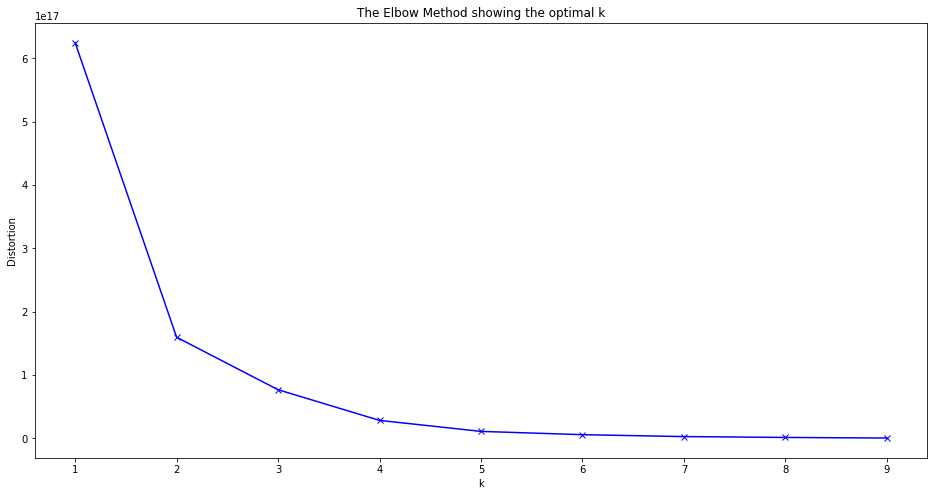

In [25]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

__Note:__ the optimal number of clusters is the value in the point after which the distortion/inertia start decreasing in a linear fashion. For this data and iteration I selected that the optimal number of clusters for the data is 3.

### Modeling
- Using __clusterNum__ = 3 

In [26]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 0 1 1 1 2 1 0 2 2 1 0 2 1 0 1 0 1 0 1 2 0 1 1 2 2 1 1 2 1 0 1 2 1 1 0 1
 0 1 2 2 1 0 2 2 2 1 2 0 0 1 2 0 2 2 1 0 0 1 1 2 1 1 1 1 2 2 1 1 2 2 1 1 1
 2 2 1 0 1 0 2 0 2 1]


Assign <__labels__> and <__nonprofit name__> to each row of the dataframe

In [27]:
df_np_rating_clust1 = df_np_rating.filter(['ein', 'npOrganization', 'Score',\
                                           'Rating','finScore','finRating','acctScore','acctRating'])
df_np_rating_clust1["Clus_Score"] = labels
df_np_rating_clust1.head(5)

,ein,npOrganization,Score,Rating,finScore,finRating,acctScore,acctRating,Clus_Score
0,043467254,Foundation for Individual Rights in Education,96.32,4.0,95.75,4.0,97.0,4.0,1
1,131623885,American Bible Society,85.63,3.0,81.32,3.0,92.0,4.0,0
2,131810938,Maccabi USA/Sports for Israel,87.01,3.0,81.63,3.0,100.0,4.0,1
3,202760310,Broad Street Ministry,89.78,3.0,87.97,3.0,92.0,4.0,1
4,203195763,Community Partnership School,92.29,4.0,89.87,3.0,96.0,4.0,1


### Check the centroid values on each cluster

In [30]:
df_np_rating_clust1.groupby('Clus_Score').mean()

,Score,Rating,finScore,finRating,acctScore,acctRating
Clus_Score,,,,,,
0,80.372632,2.526316,75.041053,1.947368,89.526316,3.473684
1,91.753684,3.763158,90.270000,3.552632,95.526316,3.842105
2,85.252963,2.925926,88.167778,3.296296,83.962963,2.814815


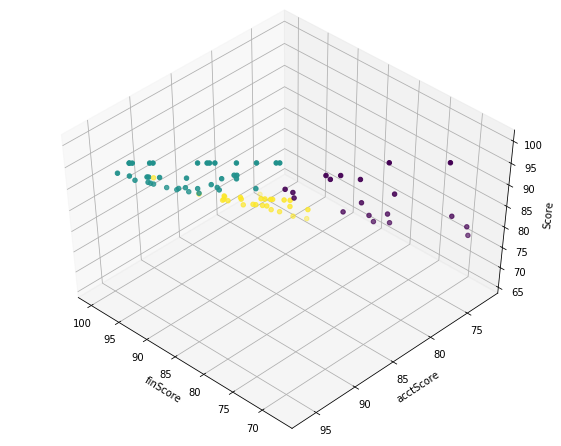

In [33]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('acctScore', fontsize=18)
# plt.xlabel('finScore', fontsize=16)
# plt.zlabel('Score', fontsize=16)
ax.set_xlabel('finScore')
ax.set_ylabel('acctScore')
ax.set_zlabel('Score')

ax.scatter(X[:, 1], X[:, 0], X[:, 2], c= labels.astype(np.float))

I have now partitioned the score data into mutually exclusive groups __(3 clusters)__. I created the following profiles for each group or cluster, considering best practice by scores __(Clus_Score)__:

- 0 EXCEPTIONAL$\;\;\;\;\;\;\;\;\;\;\;\;$Exceeds industry standards and outperforms most nonprofit.
- 1 GOOD $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$Exceeds or meets industry standards and performs as well as or better than other nonprofits.
- 2 NEED IMPROVEMENT$\;\;\;$Meets or nearly meets industry standards but underperforms most nonprofits.




### Cluster Reports 

In [34]:
df_np_cluster0 = df_np_rating_clust1.loc[df_np_rating_clust1['Clus_Score'] == 0]
df_np_cluster0 = df_np_cluster0.sort_values(by='Clus_Score',ascending = False)
df_np_cluster0 = df_np_cluster0.reset_index(drop=True)
print('-----------------------------------------------------------------------------------------------------')
print('EXCEPTIONAL - Nonprofit Organizations in Phildelphia')
print('-----------------------------------------------------------------------------------------------------')
df_np_cluster0

-----------------------------------------------------------------------------------------------------
EXCEPTIONAL - Nonprofit Organizations in Phildelphia
-----------------------------------------------------------------------------------------------------


,ein,npOrganization,Score,Rating,finScore,finRating,acctScore,acctRating,Clus_Score
0,131623885,American Bible Society,85.63,3.0,81.32,3.0,92.0,4.0,0
1,231747032,Legacy Youth Tennis and Education,81.20,3.0,75.80,2.0,89.0,3.0,0
2,262109809,Back on My Feet,79.70,2.0,72.43,2.0,92.0,4.0,0
3,237379280,National Museum of American Jewish History,73.58,2.0,67.83,1.0,81.0,3.0,0
4,232434447,National Constitution Center,85.22,3.0,81.66,3.0,90.0,4.0,0
5,232290505,Philabundance,84.19,3.0,77.85,2.0,97.0,4.0,0
6,232106589,Preservation Alliance for Greater Philadelphia,75.27,2.0,68.41,1.0,85.0,3.0,0
7,232020897,Monell Chemical Senses Center,86.22,3.0,81.82,3.0,93.0,4.0,0
8,232018929,The Fabric Workshop and Museum,78.95,2.0,74.29,2.0,85.0,3.0,0
9,231507837,Police Athletic League of Philadelphia,83.32,3.0,76.61,2.0,97.0,4.0,0


In [35]:
df_np_cluster1 = df_np_rating_clust1.loc[df_np_rating_clust1['Clus_Score'] == 1]
df_np_cluster1 = df_np_cluster1.sort_values(by='Clus_Score',ascending = False)
df_np_cluster1 = df_np_cluster1.reset_index(drop=True)
print('-----------------------------------------------------------------------------------------------------')
print('GOOD - Nonprofit Organizations in Phildelphia')
print('-----------------------------------------------------------------------------------------------------')
df_np_cluster1

-----------------------------------------------------------------------------------------------------
GOOD - Nonprofit Organizations in Phildelphia
-----------------------------------------------------------------------------------------------------


,ein,npOrganization,Score,Rating,finScore,finRating,acctScore,acctRating,Clus_Score
0,043467254,Foundation for Individual Rights in Education,96.32,4.0,95.75,4.0,97.0,4.0,1
1,232728931,Gesu School,94.27,4.0,95.92,4.0,93.0,4.0,1
2,231976386,Juvenile Law Center,91.86,4.0,88.50,3.0,100.0,4.0,1
3,232048664,Support Center for Child Advocates,91.30,4.0,87.70,3.0,100.0,4.0,1
4,232210390,Philadelphia Volunteers for the Indigent Program,94.43,4.0,93.22,4.0,96.0,4.0,1
5,232515768,Children's Literacy Initiative,91.16,4.0,87.50,3.0,100.0,4.0,1
6,232555950,Project HOME,95.89,4.0,94.20,4.0,100.0,4.0,1
7,232586142,MANNA,91.58,4.0,91.18,4.0,92.0,4.0,1
8,232710950,Research for Action,91.90,4.0,96.81,4.0,89.0,3.0,1
9,232788633,National Liberty Museum,87.22,3.0,81.93,3.0,100.0,4.0,1


In [36]:
df_np_cluster2 = df_np_rating_clust1.loc[df_np_rating_clust1['Clus_Score'] == 2]
df_np_cluster2 = df_np_cluster2.sort_values(by='Clus_Score',ascending = False)
df_np_cluster2 = df_np_cluster2.reset_index(drop=True)
print('-----------------------------------------------------------------------------------------------------')
print('NEED IMPROVEMENT - Nonprofit Organizations in Phildelphia')
print('-----------------------------------------------------------------------------------------------------')
df_np_cluster2

-----------------------------------------------------------------------------------------------------
NEED IMPROVEMENT - Nonprofit Organizations in Phildelphia
-----------------------------------------------------------------------------------------------------


,ein,npOrganization,Score,Rating,finScore,finRating,acctScore,acctRating,Clus_Score
0,205036346,Jon Bon Jovi Soul Foundation,87.83,3.0,90.00,4.0,86.0,3.0,2
1,231989161,Women's Way,88.78,3.0,88.57,3.0,89.0,3.0,2
2,311784286,BalletX,89.39,3.0,100.00,4.0,85.0,3.0,2
3,237354667,Women's Law Project,86.63,3.0,84.63,3.0,89.0,3.0,2
4,237046393,Urban Affairs Coalition,86.84,3.0,85.00,3.0,89.0,3.0,2
5,233020071,The Attic Youth Center,87.94,3.0,86.98,3.0,89.0,3.0,2
6,232936188,FringeArts,84.55,3.0,83.23,3.0,86.0,3.0,2
7,232822856,The Abraham Lincoln Foundation,77.53,2.0,89.55,3.0,70.0,2.0,2
8,232794290,Eagles Charitable Foundation,84.23,3.0,86.84,3.0,82.0,3.0,2
9,232560361,Partners for Sacred Places,81.31,3.0,86.98,3.0,77.0,2.0,2


## 5. Discussion

This basic classification system together with the map location and reports, provides some insights to potential donor and individuals about the selected nonprofit organization in the city of Philadelphia. Following some discussion bullets:

- The nonprofit locations are concentrated primarily in the downtown areas. This is an important aspect due to real-state overhead needed to maintain these organizations.
- The data showed that the largest group of nonprofits organization in the city of Philadelphia are related to Arts and Culture (aprox. 29%).
- The two components that forms the overall Score, Financial Score and Accountability Score, are not necessarily correlated in the cluster classification. Another analysis can be done to correlate these two features. 
- There is lack of data on small size nonprofit organization, and this is out of the scope set for this assignment. Small size nonprofit are important on a rating system and extending the score to other qualitative data, such as individual experience could be beneficial to tune and implement a more broad classification system.  


## 6. Conclusion

The philanthropy world is very complex and dynamic. There many reasons why a nonprofit organization exist but one common purpose is to solve a specific community needs with product and services. These organizations are tax-exempt and requires to follow a strict code of ethics and best practices for managing and maintaining their exempt status.

Nonprofit revenues largely depend on individuals and corporate contributions; thus, this money have to be allocated to the specific programs they served. Due to recent scandals and misconducts, donors need to have a reliable source of information at the time of deciding their contributions. 

In this study we achieved, using a unsupervised K-Means clustering method), a basic classification system for nonprofits with rating (revenues greater than 1M for two consecutive years) from ranking data provided recognized evaluator organization in the city of Philadelphia. Also, a series of reports were generated to add more information to potential donors.

## 7. References

- BRAY, Illona: Effective Funraising for Nonprofits. Nolo. 2010
- DeWITT, Brydon: The Nonprofit Development Companion. John Wiley & Sons, Inc., Hoboken. 2010
- Charity Navigator Blogs and API Documentation